# 05. Building Intelligent Agents

## 安装依赖

In [5]:
%uv pip install langchain~=1.0 langchain-classic~=1.0 langchain-core~=1.0 langchain-openai~=1.0 langgraph~=1.0

Audited 5 packages in 3ms
Note: you may need to restart the kernel to use updated packages.


In [2]:
%uv pip install python-dotenv~=1.1

Resolved 1 package in 45ms                                           
░░░░░░░░░░░░░░░░░░░░ [0/1] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 1 package in 15ms                                 
 + python-dotenv==1.2.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
%uv pip install 'langchain-community==1.0.0a1'

Resolved 46 packages in 93ms                                         
░░░░░░░░░░░░░░░░░░░░ [0/20] Installing wheels...                                warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 20 packages in 83ms.0.0                           
 + aiohappyeyeballs==2.6.1
 + aiohttp==3.13.2
 + aiosignal==1.4.0
 + attrs==25.4.0
 + dataclasses-json==0.6.7
 + frozenlist==1.8.0
 + greenlet==3.2.4
 + httpx-sse==0.4.3
 + langchain-classic==1.0.0
 + langchain-community==1.0.0a1
 + langchain-text-splitters==1.0.0
 + marshmallow==3.26.1
 + multidict==6.7.0
 + mypy-extensions==1.1.0
 + numpy==2.3.4
 + propcache==0.4.1
 + pydantic-settings==2.11.0
 + sqlalchemy==2.0.44
 + typing-inspect==0.9.0
 + yarl==1.22.0
N

In [ ]:
import os

import dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


class Config:
    def __init__(self):
        # By default, load_dotenv doesn't override existing environment variables and looks for a .env file in same directory as python script or searches for it incrementally higher up.
        dotenv_path = dotenv.find_dotenv(usecwd=True)
        if not dotenv_path:
            raise ValueError("No .env file found")
        dotenv.load_dotenv(dotenv_path=dotenv_path)

        api_key = os.getenv("OPENAI_API_KEY")
        if not api_key:
            raise ValueError("OPENAI_API_KEY is not set")

        base_url = os.getenv("OPENAI_API_BASE_URL")
        if not base_url:
            raise ValueError("OPENAI_API_BASE_URL is not set")

        model = os.getenv("OPENAI_MODEL")
        if not model:
            raise ValueError("OPENAI_MODEL is not set")

        embeddings_model = os.getenv("OPENAI_EMBEDDINGS_MODEL")
        hf_pretrained_embeddings_model = os.getenv("HF_PRETRAINED_EMBEDDINGS_MODEL")

        self.api_key = api_key
        self.base_url = base_url
        self.model = model
        self.embeddings_model = embeddings_model
        self.hf_pretrained_embeddings_model = (
            hf_pretrained_embeddings_model
            if hf_pretrained_embeddings_model
            else "Qwen/Qwen3-Embedding-8B"
        )

    def new_openai_like(self, **kwargs) -> ChatOpenAI:
        # 参考：https://bailian.console.aliyun.com/?tab=api#/api/?type=model&url=2587654
        # 参考：https://help.aliyun.com/zh/model-studio/models
        # ChatOpenAI 文档参考：https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html#langchain_openai.chat_models.base.ChatOpenAI
        return ChatOpenAI(
            api_key=self.api_key, base_url=self.base_url, model=self.model, **kwargs
        )

## What is a tool?

In [15]:
from langchain_core.prompts import PromptTemplate


question = "how old is the US president?"

raw_prompt_template = (
    "You have access to search engine that provides you an "
    "information about fresh events and news given the query. "
    "Given the question, decide whether you need an additional "
    "information from the search engine (reply with 'SEARCH: "
    "<generated query>' or you know enough to answer the user "
    "then reply with 'RESPONSE <final response>').\n"
    "Do not make any assumptions on recent events or things that can change."
    "Now, act to answer a user question:\n{QUESTION}"
)

prompt_template = PromptTemplate.from_template(raw_prompt_template)

llm = Config().new_openai_like()

(prompt_template | llm).invoke(question).content

'SEARCH: current US president age'

In [7]:
question1 = "What is the capital of Germany?"

(prompt_template | llm).invoke(question1).content

'RESPONSE Berlin'

In [8]:
query = "age of current US president"
search_result = (
    "Donald Trump › Age 78 years June 14, 1946\n"
    "Donald Trump 45th and 47th U.S. President Donald John Trump is an American "
    "politician, media personality, and businessman who has served as the 47th "
    "president of the United States since January 20, 2025. A member of the "
    "Republican Party, he previously served as the 45th president from 2017 to 2021. Wikipedia"
)

raw_prompt_template = (
    "You have access to search engine that provides you an "
    "information about fresh events and news given the query. "
    "Given the question, decide whether you need an additional "
    "information from the search engine (reply with 'SEARCH: "
    "<generated query>' or you know enough to answer the user "
    "then reply with 'RESPONSE <final response>').\n"
    "Today is {date}."
    "Now, act to answer a user question and "
    "take into account your previous actions:\n"
    "HUMAN: {question}\n"
    "AI: SEARCH: {query}\n"
    "RESPONSE FROM SEARCH: {search_result}\n"
)
prompt_template = PromptTemplate.from_template(raw_prompt_template)

result = (prompt_template | llm).invoke(
    {
        "question": question,
        "query": query,
        "search_result": search_result,
        "date": "Feb 2025",
    }
)

print(result.content)

RESPONSE: As of February 2025, the U.S. president is Donald Trump, who is 78 years old (born June 14, 1946).


In [9]:
query = "current US president"
search_result = "Donald Trump 45th and 47th U.S."

raw_prompt_template = (
    "You have access to search engine that provides you an "
    "information about fresh events and news given the query. "
    "Given the question, decide whether you need an additional "
    "information from the search engine (reply with 'SEARCH: "
    "<generated query>' or you know enough to answer the user "
    "then reply with 'RESPONSE <final response>').\n"
    "Today is {date}."
    "Now, act to answer a user question and "
    "take into account your previous actions:\n"
    "HUMAN: {question}\n"
    "AI: SEARCH: {query}\n"
    "RESPONSE FROM SEARCH: {search_result}\n"
)
prompt_template = PromptTemplate.from_template(raw_prompt_template)

result = (prompt_template | llm).invoke(
    {
        "question": question,
        "query": query,
        "search_result": search_result,
        "date": "Feb 2025",
    }
)
print(result.content)

SEARCH: Donald Trump birth date


### Tools in LangChain

In [10]:
search_tool = {
    "type": "function",
    "function": {
        "name": "google_search",
        "description": "Returns about common facts, fresh events and news from Google Search engine based on a query.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "title": "search_query",
                    "description": "Search query to be sent to the search engine",
                }
            },
            "required": ["query"],
        },
    },
}

step1 = llm.invoke(question, tools=[search_tool])

step1.tool_calls

[{'name': 'google_search',
  'args': {'query': 'current US president age'},
  'id': 'call_3790f052401b4e81a92eb737',
  'type': 'tool_call'}]

In [12]:
from langchain.messages import HumanMessage, ToolMessage

tool_result = ToolMessage(
    content="Donald Trump › Age 78 years June 14, 1946\n",
    tool_call_id=step1.tool_calls[0]["id"],
)
step2 = llm.invoke(
    [HumanMessage(content=question), step1, tool_result], tools=[search_tool]
)
assert len(step2.tool_calls) == 0

print(step2.content)

As of now, the current U.S. president is Joe Biden, not Donald Trump. Joe Biden was born on November 20, 1942, which makes him 81 years old (as of 2024).


In [13]:
llm_with_tools = llm.bind(tools=[search_tool])

llm_with_tools.invoke(question)

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 292, 'total_tokens': 316, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'qwen3-max-2025-09-23', 'system_fingerprint': None, 'id': 'chatcmpl-44cae3b4-8db1-4f7a-94bf-0b5fa426ce76', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--b7b908f9-8031-4a61-9fd9-29aaf4b038e8-0', tool_calls=[{'name': 'google_search', 'args': {'query': 'current US president age'}, 'id': 'call_92d1e0aae70942b79da26503', 'type': 'tool_call'}], usage_metadata={'input_tokens': 292, 'output_tokens': 24, 'total_tokens': 316, 'input_token_details': {}, 'output_token_details': {}})

### ReACT

Give the LLM access to tools as a way to interact with an external environment, and let the LLM run in a loop:
- **Reason**: Generate a text output with observations about the current situation and a plan to solve the task.
- **Act**: Take an action based on the reasoning above (interact with the environment by calling a tool, or respond to the user).

In [14]:
import math


def mocked_google_search(query: str) -> str:
    print(f"CALLED GOOGLE_SEARCH with query={query}")
    return "Donald Trump is a president of USA and he's 78 years old"


def mocked_calculator(expression: str) -> float:
    print(f"CALLED CALCULATOR with expression={expression}")
    if "sqrt" in expression:
        return math.sqrt(78 * 132)
    return 78 * 132

In [16]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

calculator_tool = {
    "type": "function",
    "function": {
        "name": "calculator",
        "description": "Computes mathematical expressions",
        "parameters": {
            "type": "object",
            "properties": {
                "expression": {
                    "type": "string",
                    "title": "expression",
                    "description": "A mathematical expression to be evaluated by a calculator",
                }
            },
            "required": ["expression"],
        },
    },
}

search_tool = {
    "type": "function",
    "function": {
        "name": "google_search",
        "description": "Returns about common facts, fresh events and news from Google Search engine based on a query.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "title": "search_query",
                    "description": "Search query to be sent to the search engine",
                }
            },
            "required": ["query"],
        },
    },
}

system_prompt = (
    "Always use a calculator for mathematical computations, and use Google Search "
    "for information about common facts, fresh events and news. Do not assume anything, keep in "
    "mind that things are changing and always "
    "check yourself with external sources if possible."
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [17]:
llm = Config().new_openai_like()

llm_with_tools = prompt | llm.bind_tools([search_tool, calculator_tool])

In [18]:
from langchain.messages import ToolMessage
from langgraph.graph import MessagesState, START, END


def invoke_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def call_tools(state: MessagesState):
    last_message = state["messages"][-1]
    tool_calls = last_message.tool_calls

    new_messages = []

    for tool_call in tool_calls:
        if tool_call["name"] == "google_search":
            tool_result = mocked_google_search(**tool_call["args"])
            new_messages.append(
                ToolMessage(content=tool_result, tool_call_id=tool_call["id"])
            )
        elif tool_call["name"] == "calculator":
            tool_result = mocked_calculator(**tool_call["args"])
            new_messages.append(
                ToolMessage(content=tool_result, tool_call_id=tool_call["id"])
            )
        else:
            raise ValueError(f"Tool {tool_call['name']} is not defined!")
    return {"messages": new_messages}


def should_run_tools(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "call_tools"
    return END

In [19]:
from langchain.messages import HumanMessage
from langgraph.graph import MessagesState, StateGraph


builder = StateGraph(MessagesState)
builder.add_node("invoke_llm", invoke_llm)
builder.add_node("call_tools", call_tools)

builder.add_edge(START, "invoke_llm")
builder.add_conditional_edges("invoke_llm", should_run_tools)
builder.add_edge("call_tools", "invoke_llm")
graph = builder.compile()

question = "What is a square root of the current US president’s age multiplied by 132?"

result = graph.invoke({"messages": [HumanMessage(content=question)]})
print(result["messages"][-1].content)

CALLED GOOGLE_SEARCH with query=current US president age
CALLED CALCULATOR with expression=sqrt(78 * 132)
The square root of the current U.S. president's age (78 years) multiplied by 132 is approximately **101.47**.


In [20]:
from langchain.agents import create_agent

agent = create_agent(
    model=llm, tools=[search_tool, calculator_tool], system_prompt=system_prompt
)

result = agent.invoke({"messages": [HumanMessage(content=question)]})
print(result)

{'messages': [HumanMessage(content='What is a square root of the current US president’s age multiplied by 132?', additional_kwargs={}, response_metadata={}, id='4af32121-83e0-4422-92a3-e51c3b10cd41'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 422, 'total_tokens': 446, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'qwen3-max-2025-09-23', 'system_fingerprint': None, 'id': 'chatcmpl-6cd6be9d-54e4-4588-a207-5c6131ad51ce', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--99c3342a-d9b4-4004-a4c2-65ae79453d2e-0', tool_calls=[{'name': 'google_search', 'args': {'query': 'current US president age'}, 'id': 'call_016171fa926d4a0592970b66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 422, 'output_tokens': 24, 'total_tokens': 446, 'input_token_details': {}, 'output_token_details': {}})]}


## Defining tools

A LangChain tool has three essential components:
- `Name`: A unique identifier for the tool
- `Description`: Text that helps the LLM understand when and how to use the tool
- `Payload schema`: A structured definition of the inputs the tool accepts

### Built-in LangChain tools

In [21]:
%uv pip install ddgs~=9.6

Resolved 17 packages in 90ms                                         
░░░░░░░░░░░░░░░░░░░░ [0/9] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 9 packages in 29ms                                
 + brotli==1.1.0
 + click==8.3.0
 + ddgs==9.6.1
 + h2==4.3.0
 + hpack==4.1.0
 + hyperframe==6.1.0
 + lxml==6.0.2
 + primp==0.15.0
 + socksio==1.0.0
Note: you may need to restart the kernel to use updated packages.


In [22]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun(api_wrapper_kwargs={"backend": "api"})
print(f"Tool's name = {search.name}")
print(f"Tool's name = {search.description}")
print(f"Tool's arg schema = {search.args_schema}")

Tool's name = duckduckgo_search
Tool's name = A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.
Tool's arg schema = <class 'langchain_community.tools.ddg_search.tool.DDGInput'>


In [23]:
from langchain_community.tools.ddg_search.tool import DDGInput


DDGInput.model_fields

{'query': FieldInfo(annotation=str, required=True, description='search query to look up')}

In [25]:
query = "What is the weather in Munich like tomorrow?"
search_input = DDGInput(query=query)
search.invoke(search_input.model_dump())

"Munich , Bavaria, Germany Weather Forecast, with current conditions, wind, air quality, and what to expect for the next 3 days. 4 days ago · Get the latest hourly weather updates for Munich tomorrow . Detailed forecast including temperature, wind, rain, snow, and UV index. Stay informed about tomorrow 's weather conditions in Munich . 6 days ago · Munich , Germany - Detailed weather forecast for tomorrow . Hourly forecast for tomorrow - including weather conditions, temperature, pressure, humidity, precipitation, dewpoint, wind, visibility, and UV index data. Oct 25, 2025 · Detailed weather forecast ⚡ in Munich , Bavaria today, tomorrow and 7 days. Wind, precipitation, 🌡️ air temperature, clouds and atmospheric pressure - World-Weather.info Oct 24, 2025 · Latest weather forecast for Munich for tomorrow 's, hourly weather forecast, including tomorrow 's temperatures in Munich , wind, rain and more. Oct 3, 2025 · Today's and tonight's professional weather forecast for Munich . Precipita

In [26]:
# llm.invoke(query, tools=[search]) 会报 search 不是合法的 json 对象。
llm.bind_tools([search]).invoke(query)

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 295, 'total_tokens': 321, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'qwen3-max-2025-09-23', 'system_fingerprint': None, 'id': 'chatcmpl-41d3c644-1a17-4f7f-8e59-1e9511952090', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--d0cba704-9624-4846-823e-74afb4fead6a-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'weather in Munich tomorrow'}, 'id': 'call_b444671c69a64c41a150b83c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 295, 'output_tokens': 26, 'total_tokens': 321, 'input_token_details': {}, 'output_token_details': {}})

In [27]:
result = llm.bind_tools([search]).invoke(
    [
        (
            "system",
            "Always use a duckduckgo_search tool for queries that require a fresh information",
        ),
        ("user", "How much is 2+2?"),
    ]
)
assert not result.tool_calls

In [28]:
from langchain.agents import create_agent


agent = create_agent(
    model=llm,
    tools=[search],
    system_prompt="Always use a duckduckgo_search tool for queries that require a fresh information",
)

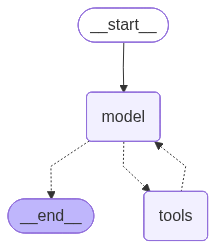

In [29]:
from IPython.display import Image, display


display(Image(agent.get_graph().draw_mermaid_png()))

In [30]:
for event in agent.stream({"messages": [("user", query)]}):
    messages = event.get("agent", event.get("tools", {})).get("messages", [])
    for m in messages:
        m.pretty_print()

================================= Tool Message =================================
Name: duckduckgo_search

Munich , Bavaria, Germany Weather Forecast, with current conditions, wind, air quality, and what to expect for the next 3 days. Be prepared with the most accurate 10-day forecast for Múnich , Bavaria, Germany with highs, lows, chance of precipitation from The Weather Channel and Weather.com 4 days ago · Get the latest hourly weather updates for Munich tomorrow . Detailed forecast including temperature, wind, rain, snow, and UV index. Stay informed about tomorrow 's weather conditions in Munich . 6 days ago · Munich , Germany - Detailed weather forecast for tomorrow . Hourly forecast for tomorrow - including weather conditions, temperature, pressure, humidity, precipitation, dewpoint, wind, visibility, and UV index data. Oct 24, 2025 · Latest weather forecast for Munich for tomorrow 's, hourly weather forecast, including tomorrow 's temperatures in Munich , wind, rain and more. Oct 

Other types of tools
- Tools that enhance the LLM’s knowledge. e.g. Knowledge bases: Wikipedia and Wikidata
- Tools that enhance your productivity. e.g. GmailToolkit
- Tools that give an LLM access to a code interpreter. e.g. Code execution: Python REPL and Bash
- Tools that give an LLM access to databases by writing and executing SQL code. e.g. SQLDatabase
- Tools for using other AI systems or automation. e.g. Hugging Face Hub

When integrating such tools with LangChain, consider these key aspects:
1. Authentication: Secure access to the external system
1. Payload schema: Define proper data structures for input/output
1. Error handling: Plan for failures and edge cases
1. Safety considerations: For example, when developing a SQL-to-text agent, restrict access to read-only operations to prevent unintended modifications

In [31]:
from langchain_community.agent_toolkits.openapi.toolkit import RequestsToolkit
from langchain_community.utilities.requests import TextRequestsWrapper

toolkit = RequestsToolkit(
    requests_wrapper=TextRequestsWrapper(headers={}),
    allow_dangerous_requests=True,
)

for tool in toolkit.get_tools():
    print(tool.name)

requests_get
requests_post
requests_patch
requests_put
requests_delete


In [32]:
api_spec = """
openapi: 3.0.0
info:
  title: Frankfurter Currency Exchange API
  version: v1
  description: API for retrieving currency exchange rates. Pay attention to the base currency and change it if needed.

servers:
  - url: https://api.frankfurter.dev/v1

paths:
  /v1/{date}:
    get:
      summary: Get exchange rates for a specific date.
      parameters:
        - in: path
          name: date
          schema:
            type: string
            pattern: '^\d{4}-\d{2}-\d{2}$' # YYYY-MM-DD format
          required: true
          description: The date for which to retrieve exchange rates.  Use YYYY-MM-DD format.  Example: 2009-01-04
        - in: query
          name: symbols
          schema:
            type: string
          description: Comma-separated list of currency symbols to retrieve rates for. Example: GBP,USD,EUR

  /v1/latest:
    get:
      summary: Get the latest exchange rates.
      parameters:
        - in: query
          name: symbols
          schema:
            type: string
          description: Comma-separated list of currency symbols to retrieve rates for. Example: CHF,GBP
        - in: query
          name: base
          schema:
            type: string
          description: The base currency for the exchange rates. If not provided, EUR is used as a base currency. Example: USD
"""

<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2478089/2022118673.py:20: SyntaxWarning: invalid escape sequence '\d'
  pattern: '^\d{4}-\d{2}-\d{2}$' # YYYY-MM-DD format


In [33]:
system_message = (
    "You're given the API spec:\n{api_spec}\n"
    "Use the API to answer users' queries if possible. "
)

agent = create_agent(
    llm, toolkit.get_tools(), system_prompt=system_message.format(api_spec=api_spec)
)

query = "What is the swiss franc to US dollar exchange rate?"

events = agent.stream(
    {"messages": [("user", query)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the swiss franc to US dollar exchange rate?
================================== Ai Message ==================================
Tool Calls:
  requests_get (call_846b8d325ed741f69d31f5e0)
 Call ID: call_846b8d325ed741f69d31f5e0
  Args:
    url: https://api.frankfurter.dev/v1/latest?base=CHF&symbols=USD
================================= Tool Message =================================
Name: requests_get

{"amount":1.0,"base":"CHF","date":"2025-10-31","rates":{"USD":1.2441}}
================================== Ai Message ==================================

The Swiss Franc (CHF) to US Dollar (USD) exchange rate is **1.2441** as of October 31, 2025. This means 1 CHF is equivalent to 1.2441 USD.


### Custom tools

#### Wrapping a Python function as a tool

In [34]:
%uv pip install numexpr~=2.13

Resolved 2 packages in 52ms                                          
░░░░░░░░░░░░░░░░░░░░ [0/1] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 1 package in 15ms                                 
 + numexpr==2.14.1
Note: you may need to restart the kernel to use updated packages.


In [35]:
import numexpr as ne
import math

math_constants = ({"pi": math.pi, "i": 1j, "e": math.exp},)
ne.evaluate(("2+2"), local_dict=math_constants)

array(4, dtype=int32)

In [36]:
from langchain.tools import tool


@tool
def calculator(expression: str) -> str:
    """Calculates a single mathematical expression, incl. complex numbers.

    Always add * to operations, examples:
      73i -> 73*i
      7pi**2 -> 7*pi**2
    """
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)

In [37]:
from langchain.tools import BaseTool


assert isinstance(calculator, BaseTool)

print(f"Tool name: {calculator.name}")
print(f"Tool description: {calculator.description}")
print(f"Tool schema: {calculator.args_schema.model_json_schema()}")

Tool name: calculator
Tool description: Calculates a single mathematical expression, incl. complex numbers.

    Always add * to operations, examples:
      73i -> 73*i
      7pi**2 -> 7*pi**2
Tool schema: {'description': 'Calculates a single mathematical expression, incl. complex numbers.\n\nAlways add * to operations, examples:\n  73i -> 73*i\n  7pi**2 -> 7*pi**2', 'properties': {'expression': {'title': 'Expression', 'type': 'string'}}, 'required': ['expression'], 'title': 'calculator', 'type': 'object'}


In [38]:
from langchain.agents import create_agent


query = "How much is 2+3i squared?"

llm = Config().new_openai_like()

agent = create_agent(llm, [calculator])

for event in agent.stream({"messages": [("user", query)]}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How much is 2+3i squared?
================================== Ai Message ==================================
Tool Calls:
  calculator (call_8324b94d7cb14d0599a53217)
 Call ID: call_8324b94d7cb14d0599a53217
  Args:
    expression: (2+3*i)**2
================================= Tool Message =================================
Name: calculator

(-5+12j)
================================== Ai Message ==================================

The square of $ 2 + 3i $ is $ -5 + 12i $.


In [40]:
from langchain_community.tools import DuckDuckGoSearchRun


search = DuckDuckGoSearchRun()

question = "What is a square root of the current US president's age multiplied by 132?"

system_hint = "Think step-by-step. Always use search to get the fresh information about events or public facts that can change over time. Now is 2025 and remember president elections in the US recently happened."

agent = create_agent(llm, [calculator, search], system_prompt=system_hint)

for event in agent.stream({"messages": [("user", question)]}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is a square root of the current US president's age multiplied by 132?
================================== Ai Message ==================================

To calculate the square root of the current U.S. president's age multiplied by 132, I first need to determine the current president's age. Since it is 2025 and recent U.S. presidential elections have occurred, I will find out who the current president is and their age.
Tool Calls:
  duckduckgo_search (call_685407e558684105806589ba)
 Call ID: call_685407e558684105806589ba
  Args:
    query: current US president 2025 age
================================= Tool Message =================================
Name: duckduckgo_search

9 hours ago - It adds a work requirement to Medicaid of 20-hour a week with some exceptions such as disability or a dependent child under age 15. It also increases money for border security and other Republican priorities. Over the 

#### Creating a tool from a Runnable

In [41]:
from langchain_core.runnables import RunnableLambda
from langchain_core.tools import convert_runnable_to_tool


def calculator(expression: str) -> str:
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


calculator_with_retry = RunnableLambda(calculator).with_retry(
    wait_exponential_jitter=True,
    stop_after_attempt=3,
)

In [42]:
calculator_tool = convert_runnable_to_tool(
    calculator_with_retry,
    name="calculator",
    description=(
        "Calculates a single mathematical expression, incl. complex numbers."
        "'\nAlways add * to operations, examples:\n73i -> 73*i\n"
        "7pi**2 -> 7*pi**2"
    ),
    arg_types={"expression": "str"},
)

In [43]:
# 原书的错误调用方式：
#   llm.invoke("How much is (2+3i)**2", tools=[calculator_tool]).tool_calls[0]
# 具体错误提示片段为：
#  Unable to serialize unknown type: <class 'method'>

llm.bind_tools([calculator_tool]).invoke("How much is (2+3i)**2")

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 309, 'total_tokens': 337, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'qwen3-max-2025-09-23', 'system_fingerprint': None, 'id': 'chatcmpl-0b7ce397-6473-461b-9c16-300f57259e58', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--1f4faffe-dada-4443-983d-fc8388f45031-0', tool_calls=[{'name': 'calculator', 'args': {'__arg1': '(2+3*i)**2'}, 'id': 'call_9e63ba38fab54505abf30c59', 'type': 'tool_call'}], usage_metadata={'input_tokens': 309, 'output_tokens': 28, 'total_tokens': 337, 'input_token_details': {}, 'output_token_details': {}})

In [45]:
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableConfig, RunnableLambda
from langchain_core.tools import convert_runnable_to_tool
from langchain.tools import BaseTool


class CalculatorArgs(BaseModel):
    expression: str = Field(description="Mathematical expression to be evaluated")


def calculator(state: CalculatorArgs, config: RunnableConfig) -> str:
    expression = state["expression"]
    math_constants = config["configurable"].get("math_constants", {})
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


calculator_with_retry = RunnableLambda(calculator).with_retry(
    wait_exponential_jitter=True,
    stop_after_attempt=3,
)

calculator_tool = convert_runnable_to_tool(
    calculator_with_retry,
    name="calculator",
    description=(
        "Calculates a single mathematical expression, incl. complex numbers."
        "'\nAlways add * to operations, examples:\n73i -> 73*i\n"
        "7pi**2 -> 7*pi**2"
    ),
    args_schema=CalculatorArgs,
    arg_types={"expression": "str"},
)

assert isinstance(calculator_tool, BaseTool)

print(f"Tool name: {calculator_tool.name}")
print(f"Tool description: {calculator_tool.description}")
print(f"Args schema: {calculator_tool.args_schema.model_json_schema()}")

Tool name: calculator
Tool description: Calculates a single mathematical expression, incl. complex numbers.'
Always add * to operations, examples:
73i -> 73*i
7pi**2 -> 7*pi**2
Args schema: {'properties': {'expression': {'title': 'Expression', 'type': 'string'}}, 'required': ['expression'], 'title': 'calculator', 'type': 'object'}


In [46]:
import math


math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
config = {"configurable": {"math_constants": math_constants}}

llm = Config().new_openai_like()

# 错误调用方式：tool_call = llm.invoke("How much is (2+3i)**2", tools=[calculator_tool]).tool_calls[0]
tool_call = (
    llm.bind_tools([calculator_tool]).invoke("How much is (2+3i)**2").tool_calls[0]
)
print(tool_call)

{'name': 'calculator', 'args': {'expression': '(2+3*i)**2'}, 'id': 'call_3f56e586793b49e19c2cfb6a', 'type': 'tool_call'}


In [47]:
calculator_tool.invoke(tool_call["args"], config=config)

'(-5+12j)'

#### Subclass StructuredTool or BaseTool

In [48]:
from langchain_core.tools import StructuredTool


def calculator(expression: str) -> str:
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


calculator_tool = StructuredTool.from_function(
    name="calculator",
    description=("Calculates a single mathematical expression, incl. complex numbers."),
    func=calculator,
    args_schema=CalculatorArgs,
)

llm.bind_tools([calculator_tool]).invoke("How much is (2+3i)**2").tool_calls[0]

{'name': 'calculator',
 'args': {'expression': '(2+3j)**2'},
 'id': 'call_0453f9588b5c4b90adbb1266',
 'type': 'tool_call'}

### Error handling

In [50]:
from langchain_core.tools import StructuredTool
from langchain.agents import create_agent


def calculator(expression: str) -> str:
    """Calculates a single mathematical expression, incl. complex numbers."""
    return str(ne.evaluate(expression.strip(), local_dict={}))


calculator_tool = StructuredTool.from_function(func=calculator, handle_tool_error=True)

agent = create_agent(llm, [calculator_tool])

for event in agent.stream(
    {"messages": [("user", "How much is (2+3i)^2")]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How much is (2+3i)^2
================================== Ai Message ==================================
Tool Calls:
  calculator (call_13f279828fb944be9bb96ff2)
 Call ID: call_13f279828fb944be9bb96ff2
  Args:
    expression: (2+3i)^2


SyntaxError: invalid decimal literal (<expr>, line 1)

## Advanced tool-calling capabilities

## Incorporating tools into workflows

### Controlled generation

In [51]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: list[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [52]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=Plan)

prompt = PromptTemplate.from_template(
    "Prepare a step-by-step plan to solve the given task. "
    "{format_instructions}."
    "TASK:\n{task}\n"
).partial(format_instructions=parser.get_format_instructions())

query = "How to write a bestseller on Amazon about generative AI?"

result = (prompt | llm.with_structured_output(Plan)).invoke(query)

In [53]:
assert isinstance(result, Plan)

print(f"Amount of steps: {len(result.steps)}")

for step in result.steps:
    print(step)
    break

Amount of steps: 11
Research the market to identify popular generative AI topics and gaps in existing books on Amazon.


#### Controlled generation provided by the vendor

In [54]:
from langchain_core.prompts import PromptTemplate


prompt = PromptTemplate.from_template(
    "Prepare a step-by-step plan to solve the given task.\n"
    "Output the planned steps as a JSON array.\n"
    "TASK:\n{task}\n"
)

plan_schema = {
    "type": "ARRAY",
    "items": {
        "type": "OBJECT",
        "properties": {
            "step": {"type": "STRING"},
        },
    },
}

query = "How to write a bestseller on Amazon about generative AI?"

result = (
    prompt | llm.with_structured_output(schema=plan_schema, method="json_mode")
).invoke(query)

In [55]:
assert isinstance(result, list)
print(f"Amount of steps: {len(result)}")
print(result[0])

Amount of steps: 14
Define your target audience (e.g., beginners, professionals, entrepreneurs) and clarify their pain points related to generative AI.


In [56]:
from enum import Enum
from pydantic import TypeAdapter


class ReviewTone(str, Enum):
    positive = "positive"
    negative = "negative"
    neutral = "neutral"


model_json_schema = TypeAdapter(ReviewTone).json_schema()

In [57]:
import json

print(json.dumps(model_json_schema, indent=2))

{
  "enum": [
    "positive",
    "negative",
    "neutral"
  ],
  "title": "ReviewTone",
  "type": "string"
}


In [58]:
from langchain_core.prompts import PromptTemplate


prompt = PromptTemplate.from_template(
    "Classify the tone of the following customer's review:"
    "\n{review}\n"
    "Output in JSON."
)

review = "I like this movie!"
llm_enum = (
    Config()
    .new_openai_like()
    .with_structured_output(schema=model_json_schema, method="json_mode")
)
result = (prompt | llm_enum).invoke(review)
print(result)

{'tone': 'positive'}


### ToolNode

In [59]:
import math
import numexpr as ne
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun


search = DuckDuckGoSearchRun()


@tool
def calculator(expression: str) -> str:
    """Calculates a single mathematical expression, incl. complex numbers.

    Always add * to operations, examples:
      73i -> 73*i
      7pi**2 -> 7*pi**2
    """
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


llm_with_tools = Config().new_openai_like().bind_tools([search, calculator])

In [60]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END


def invoke_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(MessagesState)
builder.add_node("invoke_llm", invoke_llm)
builder.add_node("tools", ToolNode([search, calculator]))

builder.add_edge(START, "invoke_llm")
builder.add_conditional_edges("invoke_llm", tools_condition)
builder.add_edge("tools", "invoke_llm")
# builder.add_edge("tools", END)
builder.add_edge("invoke_llm", END)

graph = builder.compile()

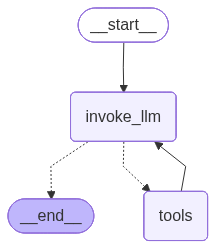

In [61]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
for e in graph.stream({"messages": ("human", "How much is 2+2")}):
    print(e)

{'invoke_llm': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 389, 'total_tokens': 412, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'qwen3-max-2025-09-23', 'system_fingerprint': None, 'id': 'chatcmpl-2a57beae-3d7a-4efc-a9cc-ec78c03e001d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--6e2290eb-7fd7-44c8-ba75-31404a2d4e73-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '2+2'}, 'id': 'call_97c56c94b6524dfcb4d7deee', 'type': 'tool_call'}], usage_metadata={'input_tokens': 389, 'output_tokens': 23, 'total_tokens': 412, 'input_token_details': {}, 'output_token_details': {}})]}}
{'tools': {'messages': [ToolMessage(content='4', name='calculator', id='7b49626d-6f4b-4b9c-bc42-49698aa5b200', tool_call_id='call_97c56c94b6524dfcb4d7deee')]}}
{'invoke_llm': {'messages': [AIMessage(content='2 + 2 equals 4.'

### Tool-calling paradigm

In [63]:
examples = [
    "I signed my contract 2 years ago",
    "I started the deal with your company in February last year",
    "Our contract started on March 24th two years ago",
]

In [64]:
from datetime import date, timedelta


@tool
def get_date(year: int, month: int = 1, day: int = 1) -> date:
    """Returns a date object given year, month and day.

    Default month and day are 1 (January) and 1.
    Examples in YYYY-MM-DD format:
      2023-07-27 -> date(2023, 7, 27)
      2022-12-15 -> date(2022, 12, 15)
      March 2022 -> date(2022, 3)
      2021 -> date(2021)
    """
    return date(year, month, day).isoformat()


@tool
def time_difference(
    days: int = 0, weeks: int = 0, months: int = 0, years: int = 0
) -> date:
    """Returns a date given a difference in days, weeks, months and years relative to the current date.

    By default, dayss, weeks, months and years are 0.
    Examples:
      two weeks ago -> time_difference(weeks=2)
      last year -> time_difference(years=1)
    """
    dt = date.today() - timedelta(days=days, weeks=weeks)
    new_year = dt.year + (dt.month - months) // 12 - years
    new_month = (dt.month - months) % 12
    return dt.replace(year=new_year, month=new_month)

In [65]:
from langchain.agents import create_agent


llm = Config().new_openai_like()

agent = create_agent(
    llm,
    [get_date, time_difference],
    system_prompt="Extract the starting date of a contract. Current year is 2025.",
)


for example in examples:
    result = agent.invoke({"messages": [("user", example)]})
    print(example, result["messages"][-1].content)
    print()

I signed my contract 2 years ago The starting date of your contract is November 1, 2023.

I started the deal with your company in February last year The contract started in February 2024.

Our contract started on March 24th two years ago The contract started on March 24th, 2023.



## What are agents?

### Plan-and-solve agent

In [66]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: list[str] = Field(
        description="different steps to follow, should be in sorted order"
    )


system_prompt_template = (
    "For the given task, come up with a step by step plan.\n"
    "This plan should involve individual tasks, that if executed correctly will "
    "yield the correct answer in JSON format and recorded in field 'steps'.\n"
    "Do not add any superfluous steps.\n"
    "The result of the final step should be the final answer. Make sure that each "
    "step has all the information needed - do not skip steps."
)
planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_template),
        ("user", "Prepare a plan how to solve the following task:\n{task}\n"),
    ]
)

llm = Config().new_openai_like(temperature=1.0)

planner = planner_prompt | llm.with_structured_output(Plan)

In [67]:
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableLambda, RunnableConfig
from langchain_core.tools import convert_runnable_to_tool


class CalculatorArgs(BaseModel):
    expression: str = Field(description="Mathematical expression to be evaluated")


def calculator(state: CalculatorArgs, config: RunnableConfig) -> str:
    expression = state["expression"]
    math_constants = config["configurable"].get("math_constants", {})
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


calculator_with_retry = RunnableLambda(calculator).with_retry(
    wait_exponential_jitter=True,
    stop_after_attempt=3,
)

calculator_tool = convert_runnable_to_tool(
    calculator_with_retry,
    name="calculator",
    description=(
        "Calculates a single mathematical expression, incl. complex numbers."
        "'\nAlways add * to operations, examples:\n73i -> 73*i\n"
        "7pi**2 -> 7*pi**2"
    ),
    args_schema=CalculatorArgs,
    arg_types={"expression": "str"},
)

In [68]:
%uv pip install arxiv==2.2.0 wikipedia==1.4.0

Resolved 12 packages in 73ms                                         
░░░░░░░░░░░░░░░░░░░░ [0/6] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 6 packages in 13ms                                
 + arxiv==2.2.0
 + beautifulsoup4==4.14.2
 + feedparser==6.0.12
 + sgmllib3k==1.0.0
 + soupsieve==2.8
 + wikipedia==1.4.0
Note: you may need to restart the kernel to use updated packages.


In [69]:
from langchain_classic.agents import load_tools

llm = Config().new_openai_like()

tools = load_tools(tool_names=["ddg-search", "arxiv", "wikipedia"], llm=llm) + [
    calculator_tool
]

In [70]:
from langchain.agents import AgentState, create_agent


system_prompt = (
    "You're a smart assistant that carefully helps to solve complex tasks.\n"
    " Given a general plan to solve a task and a specific step, work on this step. "
    " Don't assume anything, keep in minds things might change and always try to "
    "use tools to double-check yourself.\n"
    " Use a calculator for mathematical computations, use Search to gather"
    "for information about common facts, fresh events and news, use Arxiv to get "
    "ideas on recent research and use Wikipedia for common knowledge."
)

step_template = (
    "Given the task and the plan, try to execute on a specific step of the plan.\n"
    "TASK:\n{task}\n\nPLAN:\n{plan}\n\nSTEP TO EXECUTE:\n{step}\n"
)

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("user", step_template),
    ]
)


class StepState(AgentState):
    plan: str
    step: str
    task: str


execution_agent = create_agent(
    model=llm,
    tools=tools,
    state_schema=StepState,
    system_prompt=prompt_template,
)

In [71]:
from typing import Annotated, TypedDict
import operator


class PlanState(TypedDict):
    task: str
    plan: Plan
    past_steps: Annotated[list[str], operator.add]
    final_response: str


def get_current_step(state: PlanState) -> int:
    """Returns the number of current step to be executed."""
    return len(state.get("past_steps", []))


def get_full_plan(state: PlanState) -> str:
    """Returns formatted plan with step numbers and past results."""
    full_plan = []
    for i, step in enumerate(state["plan"].steps):
        full_step = f"# {i+1}. Planned step: {step}\n"
        if i < get_current_step(state):
            full_step += f"Result: {state['past_steps'][i]}\n"
        full_plan.append(full_step)
    return "\n".join(full_plan)

In [72]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END


final_prompt = PromptTemplate.from_template(
    "You're a helpful assistant that has executed on a plan."
    "Given the results of the execution, prepare the final response.\n"
    "Don't assume anything\nTASK:\n{task}\n\nPLAN WITH RESUlTS:\n{plan}\n"
    "FINAL RESPONSE:\n"
)


async def _build_initial_plan(state: PlanState) -> PlanState:
    print(f"task: {state['task']}")
    plan = await planner.ainvoke(state["task"])
    print(f"plan: {plan}")
    print(f"plan.steps: {len(plan.steps)}")
    return {"plan": plan}


async def _run_step(state: PlanState) -> PlanState:
    print(f"state: {state}")
    plan = state["plan"]
    current_step = get_current_step(state)
    step = await execution_agent.ainvoke(
        {
            "plan": get_full_plan(state),
            "step": plan.steps[current_step],
            "task": state["task"],
        }
    )
    return {"past_steps": [step["messages"][-1].content]}


async def _get_final_response(state: PlanState) -> PlanState:
    final_response = await (final_prompt | llm).ainvoke(
        {"task": state["task"], "plan": get_full_plan(state)}
    )
    return {"final_response": final_response}


def _should_continue(state: PlanState) -> Literal["run", "response"]:
    if get_current_step(state) < len(state["plan"].steps):
        return "run"
    return "response"


builder = StateGraph(PlanState)
builder.add_node("initial_plan", _build_initial_plan)
builder.add_node("run", _run_step)
builder.add_node("response", _get_final_response)

builder.add_edge(START, "initial_plan")
builder.add_edge("initial_plan", "run")
builder.add_conditional_edges("run", _should_continue)
builder.add_edge("response", END)

graph = builder.compile().with_config({"recursion_limit": 50})

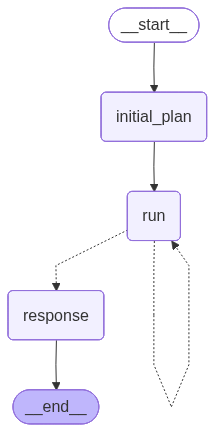

In [73]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [74]:
task = "Write a strategic one-pager of building an AI startup"

# qwen3-max-2025-09-11 无法正确生成答案，qwen3-max-2025-09-23 可以。
# 运行时间很长。
# TODO: 跑完整。
result = await graph.ainvoke({"task": task})

task: Write a strategic one-pager of building an AI startup


CancelledError: 